# Understanding Linear Regression by Deriving the Normal Equation

**Linear regression** is one of the most widely used methods for modeling relationships between a dependent variable and one or more independent variables. But what’s happening under the hood? At its core, linear regression is about finding the best-fit line by minimizing the **Sum of Squared Errors (SSE)**—a fundamental approach known as the **Least Squares Problem**.

As part of my journey through the [ML Zoomcamp course by DataTalksClub](https://datatalks.club/blog/machine-learning-zoomcamp.html), I came across the Normal Equation as a way to solve linear regression. To improve my understanding of it, I wanted to dive deeper into the underlying mathematics and derivation. This article is the result of that exploration.

In this post, we’ll walk through the mathematical foundation of linear regression, explain how it reduces to a least squares problem, and demonstrate how to solve it with Python using the Normal Equation. Along the way, we’ll cover key concepts like residuals, numerical instability, and regularization to ensure that you not only understand linear regression but can also apply it effectively in practice.

By the end, you'll have a deeper understanding of how to implement and improve linear regression models in real-world scenarios, from clean datasets to noisy, multi-dimensional data.

## Linear Regression as a Least Squares Problem

Our goal is to find the best-fitting line by minimizing the errors in our predictions. To illustrate this, let's consider a simple linear relationship where the true relationship between $x$ and $y$ is:

$$
y = 1 + 2 x
$$

To visualize this relationship, let's plot a few points.

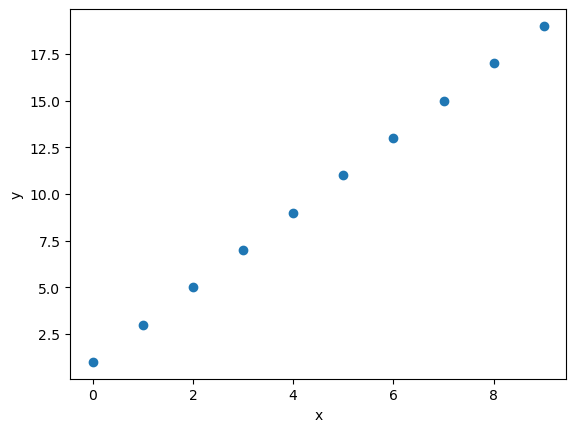

In [1]:
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(0, 10, 1)
y = 1 + 2*x

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y");

In real-world scenarios, we typically don't know the exact relationship. Instead, we are given data points, and the goal is to find the best line that fits this data. 

Let's take a look at our data:

In [2]:
for a, b in zip(x, y):
    print(f"({a}, {b})")

(0, 1)
(1, 3)
(2, 5)
(3, 7)
(4, 9)
(5, 11)
(6, 13)
(7, 15)
(8, 17)
(9, 19)


Linear regression helps us to find the weights $w_0$ and $w_1$ in the linear equation $y=w_0 + w_1 x$. These weights define the relationship between $x$ and $y$. 

However, normally we don't know $w_0$ and $w_1$ a-priori. So how do we find out? 

Let's make an arbitrary guess for the parameters $w_0$ and $w_1$. The function below takes in a guess for the weights $w_0$ and $w_1$ and returns y.

In [3]:
def predict_y(w_0, w_1):
    y = w_0 + w_1 * x
    return y

We will choose $w_0=8$ and $w_1=-1$:

$$
\hat{y} = 8 - 1 x
$$

*Note that we will denote our prediction for $y$ by a hat symbol: $\hat y$.*

This predicted line based on this guess is plotted below in red:

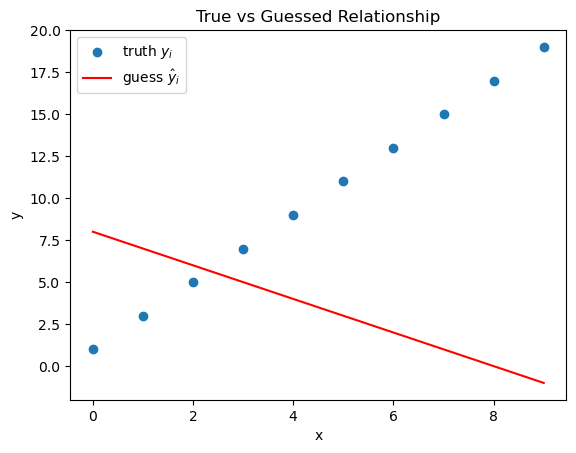

In [4]:
y_hat = predict_y(8, -1)

plt.scatter(x, y, label="truth $y_i$")
plt.plot(x, y_hat, label="guess $\hat y_i$", color="red")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("True vs Guessed Relationship");

As we can see, our guessed line is far from the true relationship. To quantify how far off we are, we calculate the **residuals** - the difference between the true value of $y$ and the predicted value $\hat{y}$. For each data point, we can compute the residual as:
$$
{residual}_{i} = y_i - \hat{y}_i
$$

Next, let's visualize these residuals as the vertical dashed lines between the true points and the guessed line:

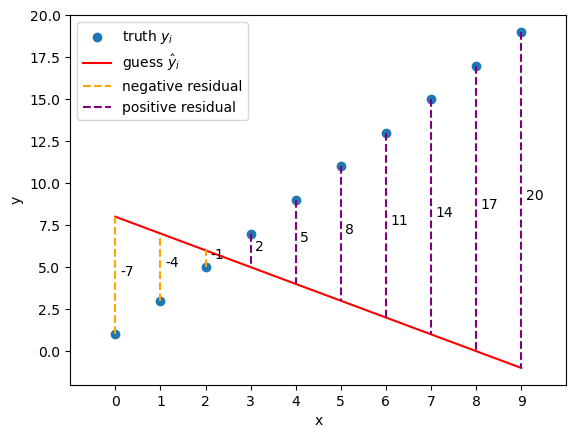

In [5]:
residuals = y - y_hat

# Visualize the residuals
plt.scatter(x, y, label="truth $y_i$")
plt.plot(x, y_hat, label="guess $\hat y_i$", color="red")
for i, residual in enumerate(residuals):
    color = "orange" if residual < 0 else "purple"
    label = "negative residual" if residual<0 and i==0 else ("positive residual" if i==len(residuals)-1 else None)
    plt.plot((x[i], x[i]), (y[i], y_hat[i]), linestyle="--", color=color, label=label)
    plt.text(x[i] + 0.1, y[i] - residuals[i]/2, s=f"{residuals[i]:.0f}")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(x);
plt.xlim((-1, 10));

In the plot, orange lines represent negative residuals (where the predicted value is larger than the actual value), and purple lines represent positive residuals. Our goal is to minimize the residuals to find the best fitting line.

One approach to achieve this is to find $w_0$ and $w_1$ by minimizing the sum of the residuals across all $m$ data points:

$$
\sum_i^M {(y_i - \hat{y_i})} = \sum_i^M({y_i - (w_0 + w_1 x_i))}
$$

However, as is visible in the plot above, some residuals are positive and others are negative. Summing them would lead to the positive and negative residuals cancelling each other to some extent, making the fit appear better than it is. To avoid this, we **square the residuals** before summing them, which gives us the **Sum of Squared Errors (SSE)**:

$$
J(\mathbf{w}) = \sum_i^M{(y_i - \hat{y_i})^2} = \sum_i^M{(y_i - (w_0 + w_1 x_i))^2}
$$

We refer to $J$ as the **cost function** or **objective function**. Finding $w_0$ and $w_1$ that minimize $J$ is what is known as the **Least Squares Problem**.

Let's visualize $J$ for our arbitrary guess $\hat{y}=8-x$

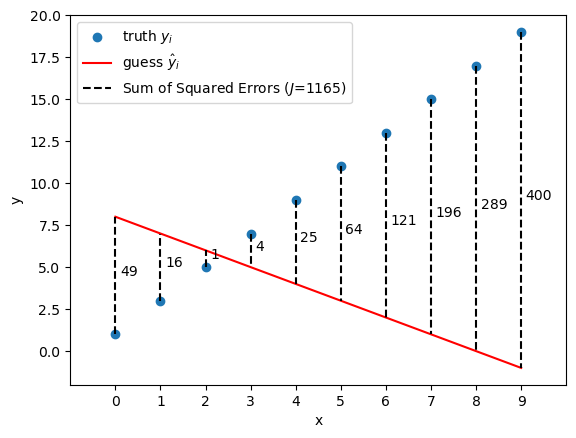

In [6]:
def plot_model(x, y, y_hat):
    residuals = (y - y_hat)
    
    plt.scatter(x, y, label="truth $y_i$")
    plt.plot(x, y_hat, label="guess $\hat y_i$", color="red")
    for i, _ in enumerate(y):
        plt.plot((x[i], x[i]), (y[i], y_hat[i]), linestyle="--", color="black", label=f"Sum of Squared Errors ($J$={round((residuals**2).sum(), 2)})" if i==0 else None)
        plt.text(x[i] + 0.1, y[i] - 0.5 * residuals[i], s=round(residuals[i]**2, 1))
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(x)
    plt.xlim((-1, 10))

plot_model(x, y, y_hat)


Squaring ensures that any deviation between our predictions and the actual values, whether positive or negative, is penalized. Additionally, squaring the residuals gives us a **differentiable function**, allowing for a **closed-form solution** to this **Least Squares Problem**, which we will explore next.

## Solving the Least Squares Problem

We will now find weights such that the **SSE** is minimized. So far we've looked at a simple 2D case, but real-world datasets often involve multiple features and data points. Let's now generalize linear regression to handle such multi-dimensional cases.

### Generalizing the Least Squares Problem

In the two-dimensional case, the linear model is expressed as:

$$
y_i = w_0 + w_1 x_{i}
$$

This is useful for visualizing the concept. However, we can generalize the formulation to $N$ dimensions: 

$$
y_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \dots + w_N x_{iN}
$$

In the multi-dimensional case, instead of a single predictor $x_1$, we now have multiple predictors $x_{i1}, x_{i2}, \dots, x_{iN}$. Each of these predictors has an associated weight $w_1, w_2, \dots, w_N$.

We can write this more compactly as the dot product:

$$
y_i = \mathbf{x}_i^T \mathbf{w}
$$

Where:
$$
\mathbf{x}_i = \begin{bmatrix} 1 \\ x_{i1} \\ x_{i2} \\ \vdots \\ x_{iN} \end{bmatrix}, \quad
\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \\ \vdots \\ w_N \end{bmatrix}
$$

Next, we will rewrite the equation in matrix form. Consider that we have $M$ data points:

$$
y_1 = \mathbf{x}_1^T \mathbf{w} \\
y_2 = \mathbf{x}_2^T \mathbf{w} \\
\vdots \\
y_M = \mathbf{x}_M^T \mathbf{w}
$$

As a matrix equation this becomes:

$$
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_M 
\end{bmatrix} =
\begin{bmatrix} 
\mathbf{x}_1^T \mathbf{w}\\
\mathbf{x}_2^T \mathbf{w}\\ 
\vdots \\
\mathbf{x}_M^T \mathbf{w} \\ 
\end{bmatrix} =
\begin{bmatrix} 
\mathbf{x}_1^T \\
\mathbf{x}_2^T \\ 
\vdots \\
\mathbf{x}_M^T 
\end{bmatrix} \mathbf{w}
$$

Or, more succinctly:

$$
\mathbf y = \mathbf{X} \mathbf{w}
$$

Where:
$$
\mathbf X = 
\begin{bmatrix} 
\mathbf{x}_1^T \\
\mathbf{x}_2^T \\ 
\vdots \\
\mathbf{x}_M^T 
\end{bmatrix} =
\begin{bmatrix} 
1 && x_{11} && x_{12} && ... && x_{1N} \\
1 && x_{21} && x_{22} && ... && x_{2N} \\
\vdots && \vdots && \vdots && \ddots && \vdots \\
1 && x_{M1} && x_{M2} && ... && x_{MN}
\end{bmatrix}
$$

### Solving the Least Squares Problem with the **Normal Equation**

We can write the **Sum of Squared Errors** for the generalized form as:

$$
J = \| \mathbf{y} - \mathbf{X} \mathbf{w} \|_2^2 = (\mathbf{y} - \mathbf{X} \mathbf{w})^T (\mathbf{y} - \mathbf{X} \mathbf{w})
$$

Expanding this expression yields:

$$
J = (\mathbf{y}^T - \mathbf{w}^T \mathbf{X}^T) (\mathbf{y} - \mathbf{X} \mathbf{w}) =
\mathbf{y}^T \mathbf{y} \underbrace{- \mathbf{y}^T \mathbf{X} \mathbf{w} - \mathbf{w}^T \mathbf{X}^T \mathbf{y}}_{\text {equal terms}} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w}
$$

A scalar value's transpose is equal to itself. If we take the transpose of $\mathbf{w}^T \mathbf{X}^T \mathbf{y}$, we get:

$$
(\mathbf{w}^T \mathbf{X}^T \mathbf{y})^T = \mathbf{y}^T \mathbf{X} \mathbf{w}
$$

Thus the middle two terms are equal and can be combined into:

$$
\mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \mathbf{w} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w}
$$

To find the optimal weights $\mathbf w$, we take the derivative of $J$ with respect to $\mathbf w$ and set it equal to 0:

$$
\frac {\partial J} {\partial \mathbf w} = 
\frac {\partial} {\partial \mathbf w} ( \mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \mathbf{w} + \mathbf{w}^T \mathbf{X}^T \mathbf{X} \mathbf{w} ) = 0
$$

Working out the derivatives and further simplification gives:

$$
\frac {\partial J} {\partial \mathbf w} = 
\mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{y}^T \mathbf{X}
$$

Finally, solving for $\mathbf{w}$, we get the **Normal Equation**:
$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} 
$$

This is called the **Normal Equation**. Given a **Design Matrix** or **Feature Matrix** $\mathbf{X}$ and a **solution vector** $\mathbf{y}$, it will yield the weights $\mathbf{w}$ which minimize the **Least Squares Error** $J$.

### Implementing the Normal Equation

Now that we have derived the Normal Equation, let's implement it in Python. We will first define a function to build our feature matrix $\mathbf{X}$, including the bias term:

In [7]:
def get_X(x):
    '''Adds the bias column to the feature matrix (corresponds to w_0)'''
    return np.column_stack([np.ones(x.shape), x])

Next, we implement the **Normal Equation**:

In [8]:

def w_normal_equation(X, y):
    '''Takes in the feature matrix X and solution vector y and returns weights vector w which minimizes SSE'''
    return np.linalg.inv(X.T @ X) @ X.T @ y


Additionally, we define the **Root Mean Square Error (RMSE)**, which is a common metric for measuring the fit of the model:

$$
RMSE = \sqrt{\frac {J} {M}}
= \sqrt{\frac{1}{M} \| \mathbf{y} - \mathbf{\hat{y}}\|_2^2}
=\sqrt{\frac{1}{M} \sum_{i}^{M} {(y_i - \hat{y_i})^2}}
$$

It represents the average error per datapoint in the same units as the target variable $y$, which is more commonly used in Machine Learning.

In [9]:
def rmse(y, y_hat):
    return np.sqrt(np.sum((y - y_hat)**2) / y.shape[0])

### Solving our Example Problem with the Normal Equation

We will now apply the Normal Equation to our example problem. First, we construct the design matrix and solve for $\mathbf{w}$:

In [11]:
X = get_X(x)
w = w_normal_equation(X, y)

print(f"w0={round(w[0], 2)}, w1={round(w[1], 2)}")

w0=1.0, w1=2.0


We can see that we found the correct weights in the linear relationship we started out with $y = 1 + 2 x$. Let's plot this:

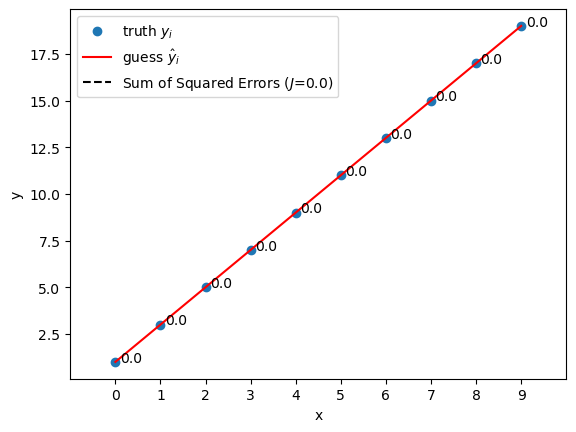

In [12]:
y_hat = X @ w

plot_model(x, y, y_hat)

Finally, calculate the RMSE (which should be 0 for this exact fit):

In [30]:
rmse(y, y_hat)

np.float64(1.191616393558691e-15)

### Numerical Stability of the Normal Equation

The Normal Equation can encounter numerical instability when solving for the inverse of $\mathbf{X}^T \mathbf{X}$. This happens particularly when $\mathbf{X}^T \mathbf{X}$ is singular or ill-conditioned — meaning that it is nearly singular, making inversion unreliable. This issue can occur when there is multicollinearity, where features are highly correlated or linearly dependent. Let's explore this problem by adding a new feature to our dataset.

Let's introduce a new feature that is perfectly collinear with the second feature (i.e., it is an exact duplicate). This will illustrate how multicollinearity affects numerical stability:

In [14]:
X_new = np.column_stack([X, X[:, -1]])
X_new


array([[1., 0., 0.],
       [1., 1., 1.],
       [1., 2., 2.],
       [1., 3., 3.],
       [1., 4., 4.],
       [1., 5., 5.],
       [1., 6., 6.],
       [1., 7., 7.],
       [1., 8., 8.],
       [1., 9., 9.]])

Our model now looks as follows:

$$
y = w_0 + w_1 x_1 + w_2 x_2
$$

Remember our solution vector $\mathbf{y}$ was created using the equation:

$$
y = 1 + 2 x
$$

Therefore, after introducing this new dimension, we expect the following solution:

$$
w_0=1, \quad w_1=2, \quad w_2=0
$$

Since the new feature is perfectly collinear, $\mathbf{X}^T \mathbf{X}$ becomes singular. When attempting to solve the Normal Equation, the matrix inversion fails, as the matrix cannot be inverted:

In [15]:
w = w_normal_equation(X_new, y)  # This throws an error: LinAlgError: Singular matrix

LinAlgError: Singular matrix

In the Normal Equation, we are calculating the inverse $(\mathbf{X}^T \mathbf{X})^{-1}$. However, matrices are not always invertible. 

A matrix has to be square to be invertible, and this condition is always satisfied in the Normal Equation because $\mathbf{X}^T \mathbf{X}$ is square by definition (even if $\mathbf{X}$ is not). 

Secondly, for a square matrix be invertible, it must be of **full rank**. This means that its columns and rows must be linearly independent. If a square matrix is not full-rank, it is said to be **rank-deficient** or **singular**, meaning it does not have an inverse. 

In our case, the matrix $\mathbf{X}$ has this problem. The third column we added to it is a duplicate of the second column making them linearly dependent. As a result $\mathbf{X}^T \mathbf{X}$ becomes rank-deficient and non-invertible.

Let's circumvent this by adding a very small number to the first element in the third column. Doing this will make the columns linearly independent (but barely so).

In [16]:
X_new[-1, -1] += 1e-5
X_new

array([[1.     , 0.     , 0.     ],
       [1.     , 1.     , 1.     ],
       [1.     , 2.     , 2.     ],
       [1.     , 3.     , 3.     ],
       [1.     , 4.     , 4.     ],
       [1.     , 5.     , 5.     ],
       [1.     , 6.     , 6.     ],
       [1.     , 7.     , 7.     ],
       [1.     , 8.     , 8.     ],
       [1.     , 9.     , 9.00001]])

The feature matrix is no longer exactly singular and therefore becomes numerically invertible.

Looking at our Gram Matrix ($\mathbf{X}^T \mathbf{X}$) we see that columns 2 and 3 are slightly different.

In [17]:
X_new.T @ X_new

array([[ 10.     ,  45.     ,  45.00001],
       [ 45.     , 285.     , 285.00009],
       [ 45.00001, 285.00009, 285.00018]])

Let's calculate the inverse of the Gram Matrix:

In [18]:
np.linalg.inv(X_new.T @ X_new)

array([[ 3.77791480e-01, -2.22317090e+04,  2.22316423e+04],
       [-2.22317089e+04,  1.52842708e+10, -1.52842624e+10],
       [ 2.22316423e+04, -1.52842624e+10,  1.52842541e+10]])

Here we see some values that are very high. If we now use this to calculate the weights, we find:

In [32]:
w_normal_equation(X_new, y)

array([ 1.00316911e+00,  2.00048589e+00, -1.38342148e-04])

This solution actually is not that bad. $w_0$ is close to 1, $w_1$ is close to 2, and $w_2$ is close to 0. Same as before. So what's the problem then?

Remember that $\mathbf{y}$ is an exact linear combination of the columns of $\mathbf{X}$. We used a linear relationship to come up with $\mathbf{y}$ based on $\mathbf{X}$. In reality however, this is never the case. To make this example more realistic and demonstrate the problem with numerical instability, we will add some noise to $\mathbf{y}$:

In [20]:
noise =  np.random.normal(0, 0.1, y.shape[0])
y_noisy = y + noise
y_noisy

array([ 1.16929295,  3.07543813,  4.96085096,  6.87538246,  9.11606843,
       11.04137308, 12.92776237, 15.04758553, 17.16615415, 18.92177221])

Now let's try to find the weights $\mathbf{w}$ with the Normal Equation:

In [34]:
w_noisy_unstable = w_normal_equation(X_new, y_noisy)
w_noisy_unstable

array([ 1.04513120e+00,  1.20819359e+04, -1.20799355e+04])

These weights are very different from what we found before. If we were to solve the Normal Equation for 2 dimensions (i.e. without linearly dependent columns) and $y_{\text{noisy}}$, we can see that the weights are actually quite close to the noiseless case:

In [22]:
w_noisy_stable = np.linalg.inv(X.T @ X) @ X.T @ y_noisy
w_noisy_stable

array([1.05952868, 1.99347541])

The corresponding RMSE is:

In [23]:
y_hat_noisy_stable = X @ w_noisy_stable

rmse(y, y_hat_noisy_stable)

np.float64(0.03551499044755408)

Our unstable solution gives use a result which does not match the ground truth. This problem of *linearly dependent features* or *multicollinearity* is common in Machine Learning. Let's look at a way to deal with this.

### Regularization

**Regularization** is a technique to make our numerical system stable. The idea is that we don't want just any weights that will give us a solution. We want to constrain the weights to remain small. What we can do is we can add a small number to the diagonal of the Gram matrix:

In [24]:
r = 1e-10
XTX_regularized = X_new.T @ X_new + r * np.eye(X_new.T.shape[0])

Let's check the inverse:

In [25]:
np.linalg.inv(XTX_regularized)

array([[ 3.53426174e-01, -5.48057250e+03,  5.48051496e+03],
       [-5.48057248e+03,  3.76787227e+09, -3.76787022e+09],
       [ 5.48051495e+03, -3.76787022e+09,  3.76786816e+09]])

The numbers are quite large after regularizing slightly, so let's increase the regularization parameter to improve stability. To gain more insight into the effect of the regularization parameter $\lambda$, we have plotted the coefficients $w_0$, $w_1$, and $w_2$ as well as the RMSE, as a function of it.

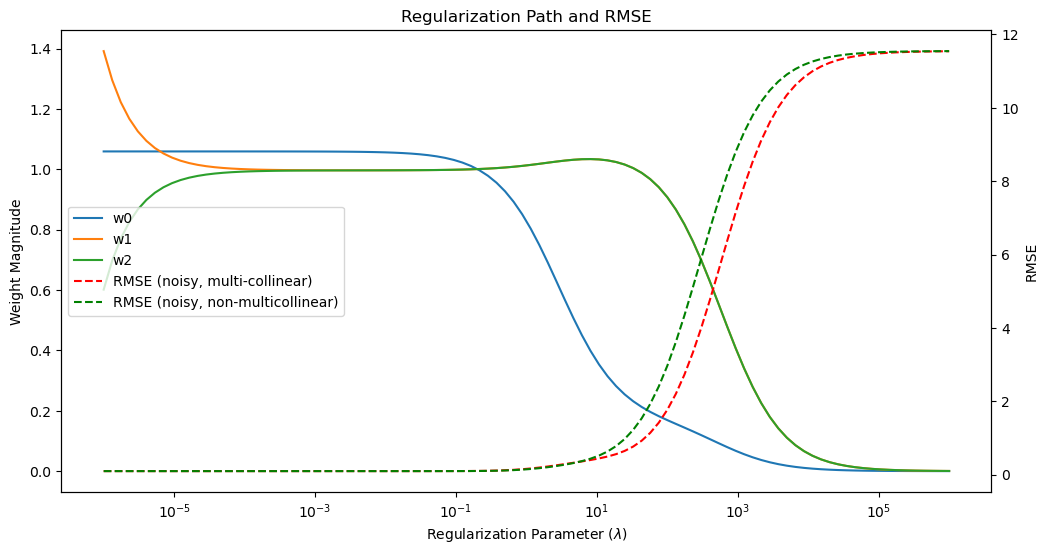

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of lambda values
lambdas = np.logspace(-6, 6, 100)
weights = []
rmse_noisy_stable = []
rmse_noisy_collinear = []

# Loop over each lambda to calculate the weights and RMSE
for r in lambdas:
    # Regularization for the multi-collinear case
    XTX_regularized = X_new.T @ X_new + r * np.eye(X_new.T.shape[0])
    w_reg = np.linalg.inv(XTX_regularized) @ X_new.T @ y_noisy
    weights.append(w_reg)
    
    # Predicted y with regularized weights for the multi-collinear case
    y_hat_noisy_reg_collinear = X_new @ w_reg
    rmse_noisy_collinear.append(rmse(y_noisy, y_hat_noisy_reg_collinear))
    
    # Regularization for the non-multicollinear case
    XTX_regularized_stable = X.T @ X + r * np.eye(X.T.shape[0])
    w_reg_stable = np.linalg.inv(XTX_regularized_stable) @ X.T @ y_noisy
    
    # Predicted y with regularized weights for the non-multicollinear case
    y_hat_noisy_reg_stable = X @ w_reg_stable
    rmse_noisy_stable.append(rmse(y_noisy, y_hat_noisy_reg_stable))

weights = np.array(weights)

# Create a plot with weights and RMSE values
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the weights for w0, w1, and w2 on primary axis
ax1.plot(lambdas, weights[:, 0], label="w0")
ax1.plot(lambdas, weights[:, 1], label="w1")
ax1.plot(lambdas, weights[:, 2], label="w2")

# Log scale for the x-axis on the primary axis
ax1.set_xscale("log")
ax1.set_xlabel("Regularization Parameter ($\lambda$)")
ax1.set_ylabel("Weight Magnitude")
ax1.set_title("Regularization Path and RMSE")

# Create a secondary y-axis for RMSE
ax2 = ax1.twinx()

# Plot the RMSE for noisy, multi-collinear case on secondary axis
ax2.plot(lambdas, rmse_noisy_collinear, label="RMSE (noisy, multi-collinear)", linestyle="--", color="red")

# Plot the RMSE for noisy, non-multicollinear case on secondary axis
ax2.plot(lambdas, rmse_noisy_stable, label="RMSE (noisy, non-multicollinear)", linestyle="--", color="green")

# Set labels for the secondary y-axis
ax2.set_ylabel("RMSE")

# Combine the legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

legend = ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left')


A few things to note:
- For small values $\lambda < 10^{-8}$, the coefficients $w_1$ and $w2$ start to explode in magnitude. SSE remains low, since they compensate each other.
- For $10^{-8} < \lambda < 10^{-1}$, the solution is stable (although it never approaches the ground truth, which is: $w_0=1$, $w_1=2$ and $w_2=0$)
- For large values $\lambda > 10^{-1}$, the regularization penalty becomes so dominant that the coefficients go to 0 and SSE shoots up.

We will pick $\lambda = 10^{-3}$:

In [27]:
r = 1e-3
XTX_regularized = X_new.T @ X_new + r * np.eye(X_new.T.shape[0])
np.linalg.inv(XTX_regularized)

array([[ 3.45333683e-01, -2.79901470e-02, -2.65361174e-02],
       [-2.79901470e-02,  5.00003286e+02, -4.99996954e+02],
       [-2.65361174e-02, -4.99996954e+02,  5.00002740e+02]])

By adding this small number to the diagonal of the Gram matrix, we reduce the linear dependency between the columns.

In [28]:
w = np.linalg.inv(XTX_regularized) @ X_new.T @ y_noisy
w

array([1.05921861, 0.99715598, 0.99636457])

The RMSE for this solution is:

In [29]:
y_hat_noisy_collinear = X_new @ w
rmse(y_noisy, y_hat_noisy_collinear)

np.float64(0.09756790727992189)

The regularized version of the Normal Equation becomes:

$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^T \mathbf{y} 
$$

This is essentially the same as adding a penalty proportional to the magnitude of the weights to avoid excessively large coefficients. This form of regression is called **Ridge Regression** or **L2 regularization**.

### Why We Are Still Not Close to the Ground Truth
 
Despite using L2 regularization to stabilize the system, we have not yet achieved the true solution of:

$$
w_0=1, \quad w_1=2, \quad w_2=0
$$

The primary reason for this discrepancy lies in multicollinearity. Since we introduced a duplicate feature (making $x_2$ perfectly collinear with $x_1$), the problem became **underdetermined**. In such a case, multiple combinations of $w_1$ and $w_2$ can yield similar predictions for $y$, which makes it impossible to isolate a unique solution without additional constraints.

### Mitigating Multicollinearity with Feature Selection

Although L2 regularization helps by shrinking the magnitude of the weights, it cannot completely remove the redundant feature. In fact, $w_1$ and $w_2$ will continue to compensate for each other, which is why the solution does not approach the ground truth of $w_2 = 0$. To address this, we need methods that can select or eliminate certain features.

Lasso Regression (L1 regularization) penalizes the sum of the absolute values of the coefficients. Unlike Ridge regression, it can shrink some coefficients exactly to zero, effectively performing feature selection.

ElasticNet, which combines L1 and L2 regularization, could also be used. It offers a balance between shrinking coefficients and selecting features.

However, it's important to note that even these methods cannot determine, purely from the data, which feature to discard when two features are perfectly collinear. In practice, **domain knowledge** would be required to decide which of the correlated features to keep. The underlying mathematical models cannot resolve this ambiguity by themselves.

## Conclusion

In this post, we dove into linear regression by deriving and solving the **Normal Equation**. We started by explaining the concept of linear regression as a **Least Squares Problem**, where the goal is to find the best-fit line that minimizes the **Sum of Squared Errors (SSE)**. Through the mathematical derivation, we showed how the Normal Equation provides a closed-form solution for this optimization problem.

Along the way, we encountered practical challenges, such as **multicollinearity**, where highly correlated features can make the system unstable. We demonstrated how this instability manifests by adding redundant features and noise to the dataset, which made it difficult for the Normal Equation to provide a reliable solution.

To address this instability, we explored the concept of regularization, particularly **Ridge Regression (L2 regularization)**, which helps to constrain the magnitude of the weights and stabilize the solution. However, we also noted that regularization alone cannot resolve the underlying issue of feature redundancy. In such cases, techniques like **Lasso Regression (L1 regularization)** or **ElasticNet** can perform feature selection, though **domain knowledge** is still crucial for making the right choices when interpreting the results.